### Exception CNN for identify dogs breeds 

#### Tutorial References 
* https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/
* http://machinememos.com/python/keras/artificial%20intelligence/machine%20learning/transfer%20learning/dog%20breed/neural%20networks/convolutional%20neural%20network/tensorflow/image%20classification/imagenet/2017/07/11/dog-breed-image-classification.html

In [1]:
import os
import keras
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
tf.__version__

Using TensorFlow backend.


'2.1.0'

### Build Keras Model

In [2]:
#base model
image_shape = (224,224,3)
base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=image_shape)
# add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
# this is the model we will train
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

### Freeze Base Model

In [3]:
base_model.trainable = False

### Compile Model

In [4]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Create data flow for training

In [5]:
image_gen_train = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
                               preprocessing_function = tf.keras.applications.xception.preprocess_input,
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
image_gen_val = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input,)

In [7]:
batch_size = 130
train_image_gen = image_gen_train.flow_from_directory('../DogsBreedsTrainingTestData/train',
                                               batch_size=batch_size,
                                               target_size=image_shape[:2],
                                               class_mode='categorical')

test_image_gen = image_gen_val.flow_from_directory('../DogsBreedsTrainingTestData/test',
                                               target_size=image_shape[:2],
                                               class_mode='categorical')

Found 16418 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


### Create Early Stop and Checkpoints

In [8]:
# Early stops detects when the model cant improve more and stops
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Save best model during training in case of failure
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))
bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = keras.callbacks.ModelCheckpoint(bst_model_path,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   verbose=1,)

### Train Model

In [9]:
epochs = 50
results = model.fit_generator(train_image_gen,
                              epochs=epochs,
                              validation_data=test_image_gen,
                              callbacks=[early_stopping, model_checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 127 steps, validate for 131 steps
Epoch 1/50
126/127 [============================>.] - ETA: 6s - loss: 2.3094 - accuracy: 0.4560 
Epoch 00001: val_loss improved from inf to 0.80667, saving model to 2020-05-19_dog_breed_model.h5
127/127 [==============================] - 948s 7s/step - loss: 2.3088 - accuracy: 0.4561 - val_loss: 0.8067 - val_accuracy: 0.7669
Epoch 2/50
126/127 [============================>.] - ETA: 2s - loss: 1.6485 - accuracy: 0.5875
Epoch 00002: val_loss did not improve from 0.80667
127/127 [==============================] - 390s 3s/step - loss: 1.6507 - accuracy: 0.5873 - val_loss: 0.9526 - val_accuracy: 0.7785
Epoch 3/50
126/127 [============================>.] - ETA: 2s - loss: 1.5536 - accuracy: 0.6090
Epoch 00003: val_loss did not improve from 0.80667
127/127 [==============================] - 385s 3s/step - loss: 1.5538 - accu

In [10]:
valid_loss, valid_accuracy = model.evaluate_generator(test_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


In [11]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.7799134850502014


In [12]:
tf.keras.models.save_model(model, 'model_final_cnn_pre_fine_tuning.h5')

### Set point parameters

#### Unfreeze superior layers

In [13]:
base_model.trainable = True

In [14]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 132


In [15]:
# we chose to train the top 2 xception blocks, i.e. we will freeze
# the first 116 layers and unfreeze the rest:
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True

In [16]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

### Train Set Point model

In [17]:
epochs = 30
hist_tune = model.fit_generator(train_image_gen,epochs=epochs,
                    validation_data=test_image_gen,
                    callbacks=[early_stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 127 steps, validate for 131 steps
Epoch 1/30
127/127 [==============================] - 399s 3s/step - loss: 1.1521 - accuracy: 0.6870 - val_loss: 1.1458 - val_accuracy: 0.7924
Epoch 2/30
127/127 [==============================] - 380s 3s/step - loss: 1.1203 - accuracy: 0.6925 - val_loss: 1.0389 - val_accuracy: 0.7924
Epoch 3/30
127/127 [==============================] - 387s 3s/step - loss: 1.1325 - accuracy: 0.6901 - val_loss: 0.9419 - val_accuracy: 0.7919
Epoch 4/30
127/127 [==============================] - 386s 3s/step - loss: 1.1108 - accuracy: 0.6970 - val_loss: 0.8940 - val_accuracy: 0.7929
Epoch 5/30
127/127 [==============================] - 386s 3s/step - loss: 1.0897 - accuracy: 0.6999 - val_loss: 0.8792 - val_accuracy: 0.7917
Epoch 6/30
127/127 [==============================] - 381s 3s/step - loss: 1.1048 - accuracy: 0.6967 - val_loss: 0.8711 - val_accuracy: 0.7912
Epoch 7/30
127/127 [============================

In [18]:
valid_loss, valid_accuracy = model.evaluate_generator(test_image_gen)

  ...
    to  
  ['...']


In [19]:
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

Validation accuracy after fine tuning: 0.7933685779571533


### Save model with fine tuning

In [20]:
model_name = 'dogs_breeds_cnn_fine_tuning.h5'
tf.keras.models.save_model(model, model_name)

### Plot Models Pre Fine Tuning

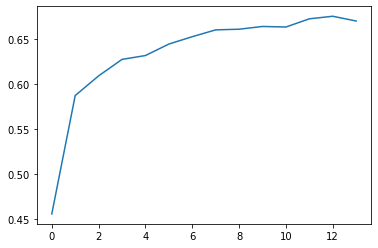

In [21]:
plt.plot(results.history['accuracy'])

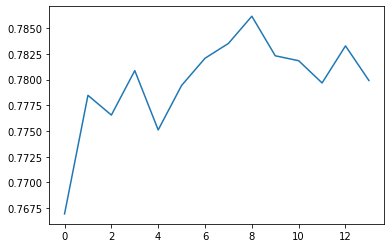

In [22]:
plt.plot(results.history['val_accuracy'])

### Plot Models Post Fine Tuning

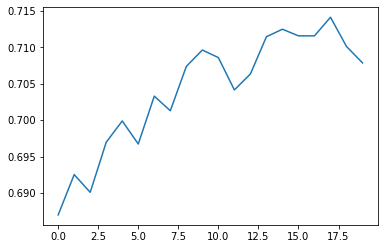

In [23]:
plt.plot(hist_tune.history['accuracy'])

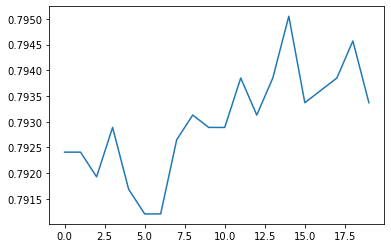

In [24]:
plt.plot(hist_tune.history['val_accuracy'])